In [1]:
# Deep Learning & ML
import tensorflow as tf
import tensorflow_probability as tfp
import keras as K
from keras import backend as Kback
from keras.models import Sequential
from keras import layers
from keras import utils as np_utils
from scipy import linalg as scila

# Linear Regression
from sklearn.linear_model import LinearRegression

# General
import numpy as np
import time

# Alerts
# import tkinter
# from tkinter import messagebox
import os as beepsnd

# General Outputs
print('TensorFlow:', tf.__version__)

Using TensorFlow backend.


TensorFlow: 2.1.0


In [2]:
N_Reconfigurations = 10**1
d = 1 # Dimension of X
D = 1 # Dimension of Y

# Data Meta-Parameters
noise_level = 0.1
uncertainty_level= 0.9

# Training meta-parameters
Epochs = 10**2


# Number of Datapoints
N_data = 10**2
# Unknown Function
def unknown_f(x):
    return np.sin(x)
%run Data_Generator.ipynb

<Figure size 640x480 with 1 Axes>

In [3]:
# Reshape Data Into Compatible Shape
data_x = np.array(data_x).reshape(-1,d)
data_y = np.array(data_y)
# Perform OLS Regression
linear_model = LinearRegression()
reg = linear_model.fit(data_x, data_y)
model_pred_y = linear_model.predict(data_x)
# Map to Graph
data_NEU = np.concatenate((data_x,model_pred_y.reshape(-1,D)),1)
NEU_targets  = data_y.reshape(-1,D)

# Reconfiguration Full

#### Helper Functions:

In [11]:
#----------------------------#
# Helper Functions T/F Functions
#----------------------------#
def bump_True(x):
    x_out = 1- tf.math.pow(tf.math.abs(x),2)
    x_out = tf.math.exp(-tf.math.divide(1,x_out))
    return x_out

def bump_False(x):
    x_out = 0
    return x_out

# Approximation to max(0,x) function by smooth function
# https://math.stackexchange.com/questions/517482/approximating-a-maximum-function-by-a-differentiable-function
def abs_helper(x):
    return tf.math.sqrt(tf.math.pow(x,2)+(10**(-5)))

def max_helper(x):
    return tf.math.multiply(abs_helper(x) + x,.5)

def soft_indicator(x):
    return max_helper(tf.math.sign(x))

In [38]:
sig = tf.random.uniform([2])
output_steps_1_2 = tf.random.normal([2])



<tf.Tensor: shape=(2,), dtype=float32, numpy=array([-1.3412416e-07, -5.7433141e-07], dtype=float32)>

In [77]:
class Reconfiguration_unit_steps(tf.keras.layers.Layer):

    def __init__(self, *args, **kwargs):
        super(Reconfiguration_unit_steps, self).__init__(*args, **kwargs)

    def build(self, input_shape):
        self.location = self.add_weight(name='location',
                                    shape=input_shape[1:],
                                    initializer='GlorotUniform',
                                    trainable=True)
        # Step 3
        self.threshold = self.add_weight(name='threshold',
                            shape=input_shape[1:],
                            initializer='GlorotNormal',
                            trainable=True)
        
        ## Steps 4-9
        self.tangentbiases = self.add_weight(name='tangentbiases',
                                    shape=input_shape[1:],
                                    initializer='GlorotNormal',
                                    trainable=True)
        self.tangentweights = self.add_weight(name='tangentweights',
                                    shape=input_shape[1:],
                                    initializer='GlorotNormal',
                                    trainable=True)
        self.location_b = self.add_weight(name='location_b',
                                    shape=input_shape[1:],
                                    initializer='GlorotUniform',
                                    trainable=True)
 

    def call(self, input):
        ### Steps 1-2
        # Relocated
        input_relocated = input + self.location
        # Rescaled
        output_steps_1_2 = input_relocated #tf.math.multiply(tf.math.abs(self.scale),input_relocated)
        
        ### Step 3
        # Bump Function (without indicator)
        output_step_3 = tf.math.divide(self.threshold,
                       sig-tf.math.pow(output_steps_1_2,
                                       2)
                      )
        # Apply Soft Indicator
        indicator_soft = soft_indicator(self.threshold - 
                                        tf.math.pow(output_steps_1_2,2)
                                       )

        # Bump function with indicator
        output_step_3 = tf.math.multiply(output_step_3,indicator_soft)
    
    
        
        ### Step 4-9
        x_out = tf.math.multiply(tf.math.abs(self.tangentweights),output_step_3) + self.tangentbiases
        
        # 7. Apply Matrix Exponential
        x_out = tf.linalg.diag(x_out)
        x_out = tf.linalg.expm(x_out)
        #x_out = x_out + tf.linalg.matmul(x_out,x_out)/2 + tf.linalg.matmul(x_out,tf.linalg.matmul(x_out,x_out))/6 +tf.linalg.matmul(x_out,tf.linalg.matmul(x_out,tf.linalg.matmul(x_out,x_out)))/24 #+tf.linalg.matmul(x_out,tf.linalg.matmul(x_out,tf.linalg.matmul(x_out,tf.linalg.matmul(x_out,x_out))))/120
        
        # TEMP: # If things are crashing use this
        #x_out = tf.math.exp(x_out)
        
        # 8. Muliply by output of (1)
        x_out = tf.linalg.matvec(x_out,input)
        
        # 9. Recenter Transformed Data
        output_steps_4_9 = x_out + self.location_b
        
        # Return Output
        return output_steps_4_9

In [78]:
projection_layer = tf.keras.layers.Lambda(lambda x: x[:, -D:])

In [79]:
# Initialize
input_layer = tf.keras.Input(shape=[d+D])
# Steps 1 and 2
reconfigure  = Reconfiguration_unit_steps()
current_layer = reconfigure(input_layer)

# Apply Reconfigurations
for i in range(N_Reconfigurations):
    reconfigure  = Reconfiguration_unit_steps()
    current_layer = reconfigure(current_layer)
    
# Map back to R^D
output_layer = projection_layer(current_layer)
NEU_OLS = tf.keras.Model(inputs=[input_layer], outputs=[output_layer])

# Summarize Model
#NEU_OLS.summary()

In [80]:
#optimizer_on = tf.keras.optimizers.SGD(learning_rate=10**(-2), momentum=0.01, nesterov=True)
NEU_OLS.compile(loss='mse',
                optimizer='sgd',
                metrics=['mse'])

In [ ]:
history = NEU_OLS.fit(
          data_NEU, NEU_targets,
          epochs=Epochs)

Train on 100 samples
Epoch 1/100


In [71]:
# Projection
NEU_prediction = NEU_OLS.predict(data_NEU)
np.shape(NEU_prediction)

(100, 1)

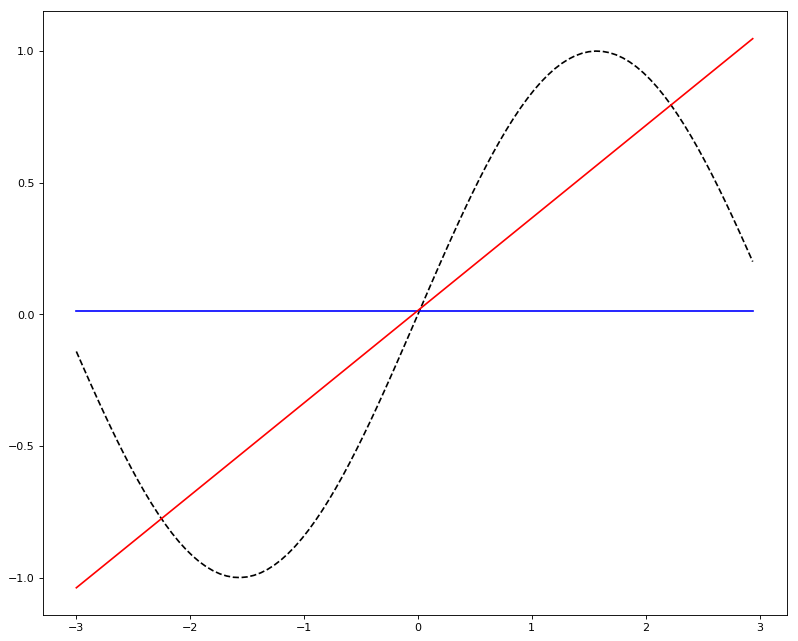

In [72]:
# import matplotlib.pyplot as plt
# Adjust Figure Details
plt.figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

# Plot Models
plt.plot(data_x,true_y,color='k',label='true',linestyle='--')
plt.plot(data_x,NEU_prediction,color='b',label='NEU-OLS')
plt.plot(data_x,model_pred_y,color='r',label='NEU-OLS')